In [1]:
# !pip install yfinance

## Modules import :

In [2]:
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import yfinance as yf
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
import statsmodels.formula.api as smf


c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Scrapping of the dates of the different ECB meetings

In order to determine the impact of ECB Council dates on the financial market, we had to retrieve the date from the ECB website.    
As the url and presentation of the meeting dates were not the same before and after 2016, we had to use two different scrapping methods to work on the two separate web pages.

### Webscrapping for the data before 2016 :

In [3]:
def scrapping_one_year_data(year, press_release):
    
    url="https://www.ecb.europa.eu/press/pr/date/"+str(year)+"/html/" +press_release+".en.html"

    # Get the page content thanks to a HTTP request
    response = requests.get(url)

    # Verify the request is satisfied
    if response.status_code == 200:
        dates = {"Governing Council": [], "General Council": [], "Press conferences": [], "All Dates": []}

        # Analyze the HTML with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Look for <div class="section" lang="en"> or <div class="section"> 
        section_divs = soup.find_all('div', class_='section', lang='en') or soup.find_all('div', class_='section')

        for section_div in section_divs:

            # Look for <h3> or <h2> to find out the meeting type
            meeting_type_list = section_div.find_all(['h3', 'h2']) # All meeting types

            for meeting_type in meeting_type_list: # If they are more than one meeting types

                if meeting_type is not None : # Check if the list is not empty 

                    meeting_type_text = meeting_type.text.strip()

                    meeting_type_key = re.findall(r'Press conferences|Governing Council|General Council', meeting_type_text) # Look for the type of the meeting 
                    key = meeting_type_key[0] if meeting_type_key else "Autre"  # Association with the dictionnary meeting type

                    # Look for the <p> to extract the dates between the <h2> or <h3>
                    next_meeting_type_tag = meeting_type.find_next(['h2','h3'])
                    dates_div = []
                    current_tag = meeting_type.find_next()

                    while current_tag and current_tag != next_meeting_type_tag:
                        if current_tag.name == 'p':
                            dates_div.append(current_tag)
                        current_tag = current_tag.find_next()

                    for date in dates_div:

                        date_match_two_days = re.search(r'(\d+/\d+)\s(\w+\s\d+)', date.text.strip() )

                        if date_match_two_days:
                            jours, mois_annee = date_match_two_days.groups()
                            jours_list = re.split(r'[-/]', jours)

                            # Combinaison des jours avec le mois et l'année pour avoir les jours de conseil distincts
                            dates_list = [f"{jour} {mois_annee}" for jour in jours_list]

                            # Delete city/country names
                            dates_without_city = [re.search(r'\d+\s\w+\s\d+', d).group() if re.search(r'\d+\s\w+\s\d+', d) else None for d in dates_list]

                            # Add dates to the list
                            dates[key].extend(dates_without_city)
                            dates["All Dates"].extend(dates_without_city)

                        else :
                            date_match_without_city = re.search(r'\d+\s\w+\s\d+', date.text.strip()) # Pour enlever les noms des villes/pays
                            date_text = date_match_without_city.group() if date_match_without_city else None
                            
                            if date_text is not None :
                                dates[key].append(date_text)
                                dates["All Dates"].append(date_text)

        return(dates)
    else:
        print(f"Échec de la requête. Code d'état : {response.status_code}")


In [4]:
def create_dataframes(dates, format_date):
    for category, date_list in dates.items():
        dates[category] = [datetime.strptime(date, format_date) for date in date_list]    

    # Create dataframes for all categories
    df_governing_council = pd.DataFrame({"Date": dates["Governing Council"]})
    df_general_council = pd.DataFrame({"Date": dates["General Council"]})
    df_press_conferences = pd.DataFrame({"Date": dates["Press conferences"]})
    df_all_dates = pd.DataFrame({"Date": dates["All Dates"]})

    return df_governing_council, df_general_council, df_press_conferences, df_all_dates


Webscrapping of the webpage : 

In [5]:
press_release=["pr070330","pr090508","pr110420","pr130517"]
years = [2007,2009,2011, 2013] 

year_press_release_pairs = zip(years, press_release)
# Initialize a dictionnary to stock the dataframe of every meeting type
df_governing_council_final = pd.DataFrame()
df_general_council_final = pd.DataFrame()
df_press_conferences_final = pd.DataFrame()
df_all_dates_final = pd.DataFrame()

# Boucler sur les paires (année, press release)
for year, press_release in year_press_release_pairs:
    # Call the webscrapping function
    dates = scrapping_one_year_data(year, press_release)
    # Create the dataframe
    df_governing_council, df_general_council, df_press_conferences, df_all_dates = create_dataframes(dates, '%d %B %Y')

    # Add the dataframe to their proper type in the dictionnary
    df_governing_council_final = pd.concat([df_governing_council_final, df_governing_council], axis=0, ignore_index=True)
    df_general_council_final = pd.concat([df_general_council_final, df_general_council], axis=0, ignore_index=True)
    df_press_conferences_final = pd.concat([df_press_conferences_final, df_press_conferences], axis=0, ignore_index=True)
    df_all_dates_final = pd.concat([df_all_dates_final, df_all_dates], axis=0, ignore_index=True)


### Webscrapping for the data after 2016 :

In [6]:
def scrapping_one_page_from_archive(date):

    url = f"https://web.archive.org/web/{date}/https://www.ecb.europa.eu/press/calendars/mgcgc/html/index.en.html"

    response = requests.get(url)

    if response.status_code == 200:

        dates = {"Governing Council": [], "General Council": [], "Press conference": [], "All Dates": []}

        # Analyser le contenu HTML avec BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Look for <div class="definition-list -zebra">
        section_divs = soup.find_all('dl', class_='pubList') or soup.find_all('div', class_='definition-list -zebra')
        
        for section_div in section_divs:
            # Look for <dd> to find out the meeting type
            meeting_type_list = section_div.find_all('dd')

            for meeting_type in meeting_type_list : 
                meeting_type_text = meeting_type.text.strip()

                # Extraction du premier type de réunion s'il y en a deux sur la même ligne
                meeting_type_key = re.findall(r'Press conference|Governing Council|General Council', meeting_type_text)
                key = meeting_type_key[0] if meeting_type_key else "Autre"

                dates_div = []

                dates_div.append(meeting_type.find_previous('dt'))
                
                for date in dates_div:
                        
                    date_match_day = re.search(r'(\d+/\d+/\d+)', date.text.strip())

                    if date_match_day:
                        date_text = date_match_day.group() if date_match_day else None

                        dates[key].append(date_text)
                        dates["All Dates"].append(date_text)
        dates["Press conferences"] = dates.pop("Press conference")
        return dates

    else:
        print(f"Échec de la requête. Code d'état : {response.status_code}")

In [7]:
dates = [20151220151041, 20170126223123, 20180128032305, 20190127223531, 20200311084017, 20210309130411, 20220103104133, 20230121220001]

for date in dates : 
    dates = scrapping_one_page_from_archive(date) 
    df_governing_council, df_general_council, df_press_conferences, df_all_dates = create_dataframes(dates, '%d/%m/%Y')

    df_governing_council_final = pd.concat([df_governing_council_final, df_governing_council], axis=0, ignore_index=True)
    df_general_council_final = pd.concat([df_general_council_final, df_general_council], axis=0, ignore_index=True)
    df_press_conferences_final = pd.concat([df_press_conferences_final, df_press_conferences], axis=0, ignore_index=True)
    df_all_dates_final = pd.concat([df_all_dates_final, df_all_dates], axis=0, ignore_index=True)


In [8]:
df_governing_council_final.drop_duplicates(inplace=True)
df_general_council_final.drop_duplicates(inplace=True)
df_press_conferences_final.drop_duplicates(inplace=True)
df_all_dates_final.drop_duplicates(inplace=True)

## STOX X50 data

In [9]:
def get_stoxx50_data(start_date, end_date):
    # Symbole du Stoxx 50 sur Yahoo Finance
    symbol = "^STOXX50E"
    
    # Récupérer les données
    data = yf.download(symbol, start=start_date, end=end_date)
    data=data[["Open","Adj Close","Close"]].copy()
    df=pd.DataFrame(data)
    df.rename(columns={"Open":"open_index","Adj Close":"stox_index","Close":"close_index"},inplace=True)

    df.reset_index(inplace=True)

    df["daily_pct_variation"] = ((df["close_index"] - df["open_index"]) / df["open_index"]) *100

    df["daily_return"] = df["stox_index"].pct_change() * 100
    df.dropna(inplace=True)

    return df

In [10]:
# Période de temps souhaitée (par exemple, du 1er janvier 2022 au 1er janvier 2023)
start_date = "2009-01-01"
end_date = "2023-01-01"

# Récupérer les données du Stoxx 50
stoxx50_data = get_stoxx50_data(start_date, end_date)


stoxx50_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,open_index,stox_index,close_index,daily_pct_variation,daily_return
1,2009-01-06,2558.340088,2578.429932,2578.429932,0.785269,0.979867
2,2009-01-07,2570.870117,2538.550049,2538.550049,-1.257165,-1.546673
3,2009-01-08,2516.860107,2516.560059,2516.560059,-0.011922,-0.866242
4,2009-01-09,2524.739990,2486.590088,2486.590088,-1.511043,-1.190910
5,2009-01-12,2482.790039,2451.870117,2451.870117,-1.245370,-1.396288


In [11]:
stoxx50_data["Is_Governing_Council_Date"] = stoxx50_data["Date"].isin(df_governing_council_final['Date']).astype(int)
stoxx50_data["Is_General_Council_Date"] = stoxx50_data["Date"].isin(df_general_council_final['Date']).astype(int)
stoxx50_data["Is_Press_conference_Date"] = stoxx50_data["Date"].isin(df_press_conferences_final['Date']).astype(int)
stoxx50_data["Is_Governing_Council_Date"] = stoxx50_data["Date"].isin(df_all_dates_final['Date']).astype(int)  # POURQUOI ?


# Modélisation de la variation du STOX X 50 

### Impact des dates des governing council

**Histogram according to the day with/without meeting :**

In [12]:
px.histogram(stoxx50_data,x="daily_return", nbins = 50, color="Is_Governing_Council_Date",barmode="overlay", opacity=0.4, histnorm= "probability density", title="Impact of the ECB governing council dates on the STOXX50 index")

**Descriptive statistics :**

In [13]:
stoxx50_data.groupby('Is_Governing_Council_Date')["daily_return"].describe()

,count,mean,std,min,25%,50%,75%,max
Is_Governing_Council_Date,,,,,,,,
0,3170.0,0.028213,1.346798,-8.616921,-0.626140,0.044921,0.690476,10.347654
1,342.0,-0.049973,1.515834,-12.401398,-0.613997,0.062908,0.651427,5.669414


**Daily representation :**

In [14]:
fig = px.line(stoxx50_data, x="Date", y="daily_return", title="Impact of the ECB governing council dates on the STOXX50 index")
# ou stox_index en y
scatter_data = stoxx50_data[stoxx50_data['Is_Governing_Council_Date'] == 1]
fig.add_trace(px.scatter(scatter_data, x="Date", y="daily_return", color='Is_Governing_Council_Date').data[0])

fig.show()

### Impact des dates des general council

**Histogram according to the day with/without meeting :**

In [15]:
px.histogram(stoxx50_data,x="daily_return", nbins = 50, color="Is_General_Council_Date",barmode="overlay", opacity=0.4, histnorm= "probability density", title="Impact of the ECB governing council dates on the STOXX50 index")

**Descriptive statistics :**

In [16]:
stoxx50_data.groupby('Is_General_Council_Date')["daily_return"].describe()

,count,mean,std,min,25%,50%,75%,max
Is_General_Council_Date,,,,,,,,
0,3456.0,0.020973,1.363046,-12.401398,-0.626485,0.044921,0.684452,10.347654
1,56.0,-0.002440,1.442860,-4.895901,-0.604261,0.120581,0.924661,3.334874


**Daily representation :**

In [17]:
fig = px.line(stoxx50_data, x="Date", y="stox_index", title="Impact of the ECB general council dates on the STOXX50 index")

scatter_data = stoxx50_data[stoxx50_data['Is_General_Council_Date'] == 1]
fig.add_trace(px.scatter(scatter_data, x="Date", y="stox_index", color='Is_General_Council_Date').data[0])

fig.show()

### Impact des dates des press conferences

The ECB Governing Council's press conference, held forty-five minutes after the announcement of its monetary policy decision in the form of a press release, is an important method of communication. This press conference is closely followed by market participants and can significantly influence their overall economic assessment.

*ref :* https://doi.org/10.1016/j.ejpoleco.2022.102230

**Histogram according to the day with/without meeting :**

In [18]:
px.histogram(stoxx50_data,x="daily_return", nbins = 50, color="Is_Press_conference_Date",barmode="overlay", opacity=0.4, histnorm= "probability density", title="Impact of the ECB governing council dates on the STOXX50 index")

**Descriptive statistics :**

In [19]:
stoxx50_data.groupby('Is_Press_conference_Date')["daily_return"].describe()

,count,mean,std,min,25%,50%,75%,max
Is_Press_conference_Date,,,,,,,,
0,3377.0,0.023850,1.340554,-8.616921,-0.626294,0.045586,0.688033,10.347654
1,135.0,-0.060709,1.864185,-12.401398,-0.536388,0.069470,0.675176,5.669414


**Daily representation :**

In [20]:
fig = px.line(stoxx50_data, x="Date", y="stox_index", title="Impact of the ECB press conferences dates on the STOXX50 index")

scatter_data = stoxx50_data[stoxx50_data['Is_Press_conference_Date'] == 1]
fig.add_trace(px.scatter(scatter_data, x="Date", y="stox_index", color='Is_Press_conference_Date').data[0])

fig.show()

**Measure of the impact with a regression :**

In [21]:
mod = smf.ols(formula='stox_index ~ Is_Press_conference_Date', data=stoxx50_data)

res = mod.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             stox_index   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.056
Date:                Mon, 01 Jan 2024   Prob (F-statistic):             0.0805
Time:                        18:20:51   Log-Likelihood:                -26859.
No. Observations:                3512   AIC:                         5.372e+04
Df Residuals:                    3510   BIC:                         5.373e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

<!-- Impact des dates des Press Conferences   -->

The press conference dates seems to be the only one that can have an impact on the stox index, as other dates coefficients(governing and general council) are not significant at 5% in the regression of the stox index on the dates.

## Checking of the stationnarity of the data

As we have seen in the precedent plots, the serie is likely to have a temporal increasing trend. In order to forecast this serie, we have to stationnarize it by differenciating the serie.

In [22]:
# on différencie l'index à prédire (fonctionne aussi avec le daily_return): 
stoxx50_data["stox_index_diff"] = stoxx50_data["stox_index"].diff()

stoxx50_data.dropna(inplace=True)

stoxx50_data.head()

,Date,open_index,stox_index,close_index,daily_pct_variation,daily_return,Is_Governing_Council_Date,Is_General_Council_Date,Is_Press_conference_Date,stox_index_diff
2,2009-01-07,2570.870117,2538.550049,2538.550049,-1.257165,-1.546673,0,0,0,-39.879883
3,2009-01-08,2516.860107,2516.560059,2516.560059,-0.011922,-0.866242,0,0,0,-21.989990
4,2009-01-09,2524.739990,2486.590088,2486.590088,-1.511043,-1.190910,0,0,0,-29.969971
5,2009-01-12,2482.790039,2451.870117,2451.870117,-1.245370,-1.396288,0,0,0,-34.719971
6,2009-01-13,2445.040039,2411.280029,2411.280029,-1.380755,-1.655475,0,0,0,-40.590088


We verify that the serie is now detrend with a unit root test (ADF test) : 

In [23]:
# Assuming df is your DataFrame with a column "Index_Value"
result_adf = adfuller(stoxx50_data['stox_index'])
print('ADF Statistic before differeciation:', result_adf[0])
print('p-value:', result_adf[1])
print("----------------------------------------------------")
result_adf_with_diff = adfuller(stoxx50_data['stox_index_diff'])
print('ADF Statistic after differenciation:', result_adf_with_diff[0])
print('p-value:', result_adf_with_diff[1])
print("----------------------------------------------------")
result_adf_with_daily_return = adfuller(stoxx50_data['daily_return'])
print('ADF Statistic with daily return:', result_adf_with_daily_return[0])
print('p-value:', result_adf_with_daily_return[1])

ADF Statistic before differeciation: -2.3443242909883923
p-value: 0.15807057669266344
----------------------------------------------------
ADF Statistic after differenciation: -60.05925298941949
p-value: 0.0
----------------------------------------------------
ADF Statistic with daily return: -60.16917814985229
p-value: 0.0


Visualisation of the time serie :

In [24]:
fig = px.line(stoxx50_data, x="Date", y="stox_index_diff", title="Plot of the STOXX50 index without the temporal trend")
fig.show()

### Construction of the BDD train/test

In [25]:
stoxx50_data_train = stoxx50_data.loc[stoxx50_data["Date"]<="2021-12-31"].copy()
stoxx50_data_test = stoxx50_data.loc[stoxx50_data["Date"]>"2021-12-31"].copy() # 1 year of test data

## Beginning of the modelisation with Time Serie modeling :

**LITERATURE :**
  - "Analysis of ARIMA-Artificial Neural Network Hybrid Model in Forecasting of Stock Market Returns", 10.9734/ajpas/2020/v6i230157

### ACF and PACF plots to find p and q :

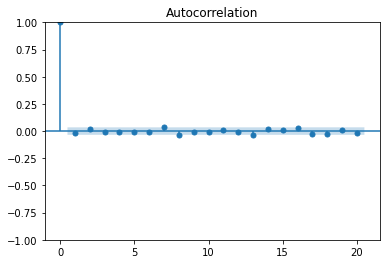

In [26]:
plot_acf(stoxx50_data_train["stox_index_diff"],lags=20)
plt.show()

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



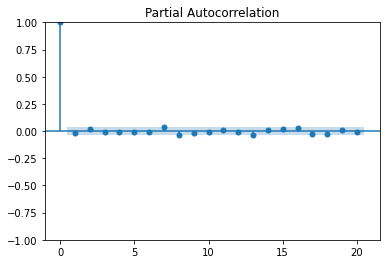

In [27]:
plot_pacf(stoxx50_data_train["stox_index_diff"],lags=20)
plt.show()

### Make grid search to fit the (p,d,q) parametres with auto_arima functions

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=33103.094, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=33104.392, Time=0.19 sec


 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=33105.720, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=33107.536, Time=0.89 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=33109.034, Time=1.01 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=33110.730, Time=1.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=33104.369, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=33105.914, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=33107.715, Time=0.75 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=33109.611, Time=0.48 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=33109.522, Time=2.72 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=33105.697, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=33107.649, Time=1.38 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=33109.901, Time=1.87 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=33111.559, Time=1.04 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=33107.561, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=33109.557, Time=0.30

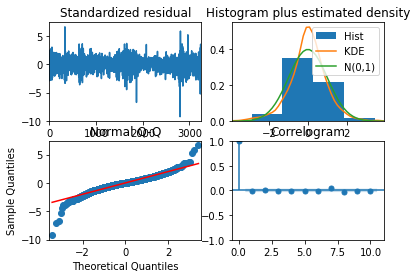

In [28]:
from pmdarima import auto_arima
model = auto_arima(
    stoxx50_data_train["stox_index"],
    test="adf",
    start_p = 0, start_q = 0, 
    max_p=6,max_q=6,
	exogenous=stoxx50_data_train["Is_Press_conference_Date"],
    stepwise = False, # to test all combinations
	trace=True,
	error_action="ignore",
	suppress_warnings=True,
	)
print(model.summary())
model.plot_diagnostics()
plt.show()

Model chosen according to the auto arima procedure :

In [29]:
arima_model = ARIMA(endog= stoxx50_data_train["stox_index"],
                            exog = stoxx50_data_train["Is_Press_conference_Date"],
                            order=(0,1,0))
model_fit = arima_model.fit()
forecast = model_fit.get_forecast(steps=len(stoxx50_data_test),
                                  exog=stoxx50_data_test["Is_Press_conference_Date"], 
                                  alpha = 0.05)
predicted_values = forecast.predicted_mean
conf_int = forecast.conf_int()

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [30]:
stoxx50_data_test["predicted_values"] = predicted_values.values
stoxx50_data_test["predicted_values_upper"] = conf_int["upper stox_index"].values
stoxx50_data_test["predicted_values_lower"] = conf_int["lower stox_index"].values

In [31]:
# Evaluate the model
mse = mean_squared_error(stoxx50_data_test["stox_index"], stoxx50_data_test["predicted_values"])
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 604.1154228425858


### Rolling forecasting procedure :

We generate a prediction for each element on the test set.  
A rolling forecasting procedure is required given the dependence on observations in prior time steps for differencing and the AR model. To this end, we re-create the ARIMA model after each new observation is received.  
we manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended at each iteration.

*ref :* https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70   
https://neptune.ai/blog/arima-vs-prophet-vs-lstm



In [32]:
############ ROLLING ARIMA MODEL ################

history = list(stoxx50_data_train["stox_index"].values)
exog_value = list(stoxx50_data_train["Is_Press_conference_Date"].values)
test_data = list(stoxx50_data_test["stox_index"].values)
exog_test_value = list(stoxx50_data_test["Is_Press_conference_Date"].values)
predicted_values = []
upper_conf = []
lower_conf = []

for time_point in range(len(stoxx50_data_test)):
    model = ARIMA(endog= history,
                         exog = exog_value,
                          order=(6,1,0))
    
    model_fit = model.fit()
    output = model_fit.get_forecast(step = 1,
                                exog = exog_test_value[time_point] 
                                )
    
    output_predicted_values = output.predicted_mean[0]
    conf_int = output.conf_int()[0]
    predicted_values.append(output_predicted_values)
    lower_conf.append(conf_int[0])
    upper_conf.append(conf_int[1])

    true_test_value = test_data[time_point]

    exog_value.append(exog_test_value[time_point])
    history.append(true_test_value)

# Add the predicted values to the test dataset 
stoxx50_data_test["predicted_values"] = predicted_values
stoxx50_data_test["predicted_values_upper"] = upper_conf
stoxx50_data_test["predicted_values_lower"] = lower_conf

In [33]:
# Evaluate the model
mse = mean_squared_error(stoxx50_data_test["stox_index"], stoxx50_data_test["predicted_values"])
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 55.50246412949188


### Plot of predicted values :

In [34]:

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=stoxx50_data_train["Date"], y=stoxx50_data_train["stox_index"], name='STOX X50 index',
                         line=dict(color='royalblue', width=1.5)))

fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["stox_index"], name='STOX X50 index real value',
                         line=dict(color='royalblue', width=3, dash = "dash")))


fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["predicted_values"], name='STOX X50 index predicted',
                         line=dict(color='purple', width=1.5)))

# Confidence interval 

fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["predicted_values_upper"], 
    line=dict(color='rgba(0,100,80,0.2)'),
    fill='tonexty',
    name='Confidence Interval upper'
))

fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["predicted_values_lower"],  
    line=dict(color='rgba(0,100,80,0.2)'),
    fill='tonexty',
    name='Confidence Interval upper' 
))

# Edit the layout
fig.update_layout(title='Impact of the ECB press conferences dates on the STOXX50 index',
                   xaxis_title='Date',
                   yaxis_title='STOXX50')



## With Prophet model from META 

18:23:34 - cmdstanpy - INFO - Chain [1] start processing
18:23:35 - cmdstanpy - INFO - Chain [1] done processing


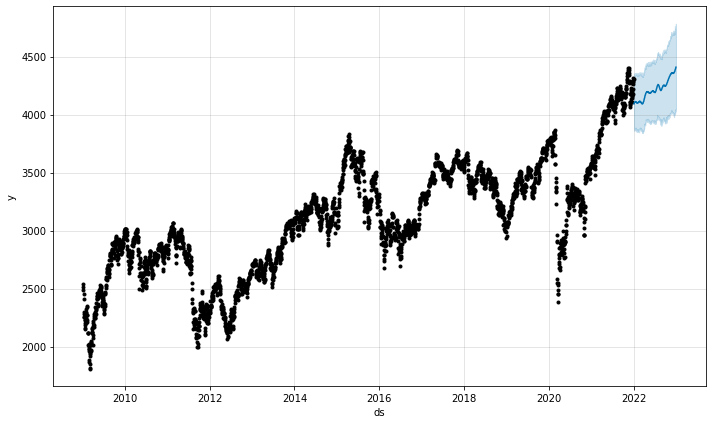

In [35]:
from prophet import Prophet

prophet = Prophet(yearly_seasonality = 'auto')
prophet.fit(stoxx50_data_train.rename(columns={"Date": "ds", "stox_index": "y"}))
# future_price = prophet.make_future_dataframe(stoxx50_data_test)
forecasts = prophet.predict(stoxx50_data_test.rename(columns={"Date": "ds", "stox_index": "y"}))
# forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot the foreasts
fig = prophet.plot(forecasts)


In [36]:
# Evaluate the model
mse = mean_squared_error(stoxx50_data_test["stox_index"], forecasts["yhat"])
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 543.6615743218264


Less good than a rolling ARIMA modeling, but better for predicting at long term